In [22]:
import matplotlib.pyplot as plt
from aerobot.utils import RESULTS_PATH, load_results_dict, DATA_PATH, FIGURES_PATH, CONTIGS_PATH
from aerobot.plot import plot_configure_mpl, PRETTY_NAMES
from aerobot.dataset import FeatureDataset
import pandas as pd
from matplotlib.gridspec import GridSpec
from scipy.stats import linregress
import numpy as np
from Bio import SeqIO
import os
from typing import List, Dict, Tuple
import scipy.optimize
import glob 

%load_ext autoreload 
%autoreload 2 

plot_configure_mpl(figure_height=2) # Want at least one color for each genome have results for. 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
CONTIGS_PATH = os.path.join(DATA_PATH, 'contigs')
# These are the feature types which I currently have results for. 
feature_types = ['aa_1mer', 'aa_2mer', 'aa_3mer']

In [24]:
# Want to get the final model accuracies for adding to the titles. 
test_accs = dict()
for feature_type in feature_types:
    results = load_results_dict(os.path.join(RESULTS_PATH, f'train_nonlinear_{feature_type}_ternary.json'))
    test_acc = results['test_acc']
    print(f'Final testing accuracy for {feature_type}: {test_acc}')
    test_accs[feature_type] = int(test_acc * 100)

Final testing accuracy for aa_1mer: 0.7403560293252575
Final testing accuracy for aa_2mer: 0.842493937752051
Final testing accuracy for aa_3mer: 0.8130292612804805


In [37]:
# Load the correct labels for each genome, as well as other metadata. Use the metadata stored in the datasets,
# as this contains extra information (like contig size).
metadata = FeatureDataset(os.path.join(CONTIGS_PATH, 'datasets.h5'), 'aa_1mer').metadata
# Organize the contigs results into DataFrames for plotting. 
contigs_results = dict() 

for feature_type in feature_types:
    predictions = pd.read_csv(os.path.join(RESULTS_PATH, f'predict_contigs_nonlinear_{feature_type}_ternary.csv'), index_col=0)
    predictions = predictions[~predictions.index.duplicated()]

    predictions = predictions.merge(metadata, how='left', left_index=True, right_index=True)
    # We want to assess contig predictions based on the whole-genome predictions. 
    # "correct" column indicates whether or not the contig prediction matches the genome prediction. 
    predictions['correct'] = predictions.prediction == predictions[f'{feature_type}_prediction']
    # predictions['correct'] = predictions.prediction == predictions.physiology.str.lower()
    contigs_results[feature_type] = predictions


In [38]:
genome_sizes = []
# Get the average size of the downloaded genomes. 
for file in os.listdir(os.path.join(CONTIGS_PATH, 'genomes')):
    genome = [str(record.seq) for record in SeqIO.parse(os.path.join(CONTIGS_PATH, 'genomes', file), 'fasta')]
    genome = ''.join(genome)
    genome_sizes.append(len(genome))
print('Mean genome size:', np.mean(genome_sizes))


Mean genome size: 3094873.420289855


# SI Figure 6


In [39]:
def plot_si_figure_6(contigs_results:Dict[str, pd.DataFrame], fig:plt.Figure=None, grids:List[GridSpec]=None):
    '''Plot the results of evaluating trained Nonlinear classifiers on contigs. The contigs are generated using closed
    genomes from the testing dataset, for which we have known labels.'''
    axes = []
    for i, feature_type in enumerate(feature_types):
        ax = fig.add_subplot(grids[i])

        # Extract the results for the specified feature type. 
        results = contigs_results[feature_type]
        
        labels, handles = [],[]
        # Group the results according to the true label of the genome...
        for label, label_df in results.groupby('physiology'):
            labels.append(label.lower())
            
            x_vals, y_vals = [], []
            for contig_size in results.contig_size.unique():
                contig_size_df = label_df[label_df.contig_size == contig_size]
                x_vals.append(contig_size)
                y_vals.append(contig_size_df.correct.mean())
            # x_vals.append(3000000)
            # y_vals.append(1)
            
            if label == 'Anaerobe':
                print(y_vals)

            handles.append(ax.scatter(x_vals, y_vals, s=10, edgecolors='k', linewidths=0.2))
            
        ax.set_xlabel('contig size')
        ax.set_yticks(np.arange(0.1, 1.0, 0.1), labels=[str(np.round(i, 2)) for i in np.arange(0.1, 1.0, 0.1)]) # Make tick labels consistent across plots.
        ax.set_ylabel('fraction matching genome prediction')
        ax.set_title(PRETTY_NAMES[feature_type] + f' ({test_accs[feature_type]}%)')
        axes.append(ax)
    
    axes[0].legend(handles=handles, labels=labels, loc='lower right')
        
    return axes # Return the axes for plotting the A, B, C labels. 



[nan, 0.06888888888888889, 0.07777777777777778, 0.09666666666666666, 0.10555555555555556, 0.11333333333333333, 0.11858608893956671, 0.1117861482381531]
[nan, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[nan, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


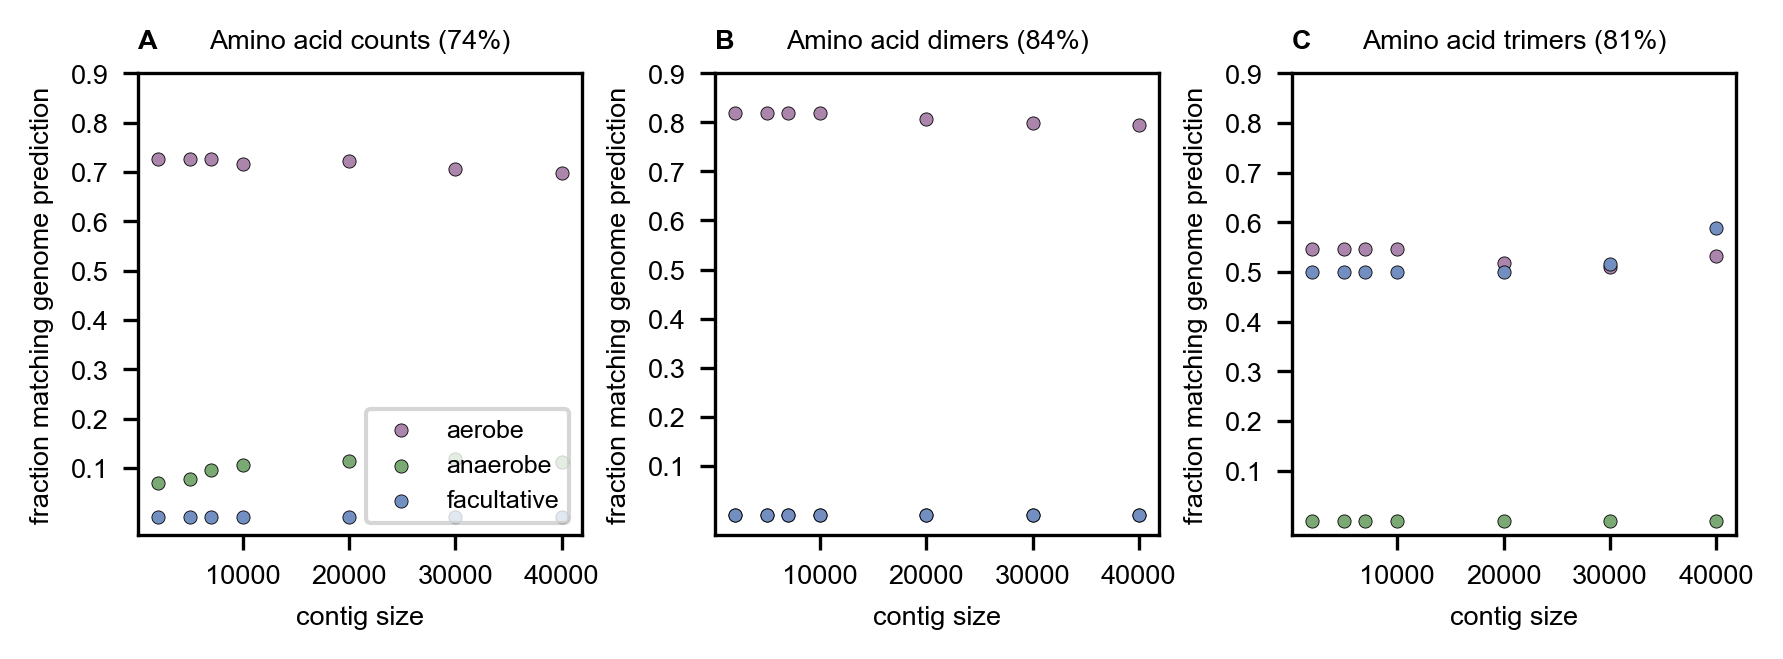

In [40]:
# n_rows, n_cols = 2, 3
n_cols = 3
fig = plt.figure()

grids = GridSpec(1, n_cols, wspace=0.3)
grids = [grids[0, i] for i in range(n_cols)] # + [grids[1, i] for i in range(n_cols)]

axes = plot_si_figure_6(contigs_results, fig=fig, grids=grids)

for ax, ax_label in zip(axes, 'ABC'):
    ax.set_title(ax_label, loc='left', fontweight='bold')

plt.savefig(os.path.join(FIGURES_PATH, 'si_fig7.png'), dpi=300, facecolor='w', bbox_inches='tight')
plt.show()